# Stack Overflow - Clustering

This notebook continues exploring the the data of the GADS23 Kaggle Stack Overflow competition.

Your goal was to build a classifier that predicts whether or not a question will be closed given the question as submitted.

Let's see if clustering would be helpful

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("/Users/ruben/Downloads/train.csv", index_col=0)

### Tags
One obvious candidate for clustering would be the vast amount of tags we have.

In [3]:
%%time
data['tags'] = data.apply(lambda x: " ".join(set(str(x['Tag%d' % i]) for i in xrange(1, 6))), axis=1)
data['tags'] = data['tags'].str.replace('nan', '').str.replace("  ", " ").str.strip()

CPU times: user 5.27 s, sys: 71.1 ms, total: 5.34 s
Wall time: 5.32 s


In [4]:
tags = set([tag for tags in data.tags.values for tag in tags.split()])
print "We have", len(tags), "tags."

We have 18309 tags.


That is a lot. We could maybe cluster these, and then feed the cluster category into the model, rather than an ID for one of the 18K tags.  We could use `CountVectorizer` for this again.

In [5]:
n_clusters = 10
# N = 10000  # only use the first N documents for clustering (to speed up computations)
# data = data.iloc[:N]

In [6]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000, min_df=10, max_df=.95, binary=True)
X = cv.fit_transform(data.tags)

CPU times: user 1.01 s, sys: 23 ms, total: 1.04 s
Wall time: 1.03 s


#### Clustering tags by their documents

In [7]:
XT = X.T
XT = StandardScaler().fit_transform(XT.toarray().astype(float))

In [8]:
%%time
model = KMeans(n_clusters=n_clusters)
model.fit(XT)

CPU times: user 4min 27s, sys: 5.2 s, total: 4min 32s
Wall time: 1min 43s


In [9]:
np.unique(model.predict(XT), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([3225,    1,    1,    2,    1,    1,    1,    1,    1,    1]))

Hmm, that didn't quite work: almost all tags got into one cluster, and the other clusters just got one tag. (Note we have less tags since we only used part of the data.)

#### Clustering documents by their tags

One other way we could do, is clustering the documents according to their tags, and then use their document cluster to feed into the model.

In [10]:
%%time
model.fit(X)

CPU times: user 32.8 s, sys: 97.6 ms, total: 32.9 s
Wall time: 32.9 s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
np.unique(model.predict(X), return_counts=True)

/Users/ruben/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:862: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([ 4100, 79086,  4237,  1996,  7608, 11944, 11935,  9816,  7418,  2132]))

Much better! Let's inspect the most common tags in these clusters.

In [12]:
top = 12
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(n_clusters):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :top]:
        print terms[ind],
    print

Top 12 tags per cluster:
Cluster 0: jquery ajax php html ui css plugins mobile json forms internet explorer
Cluster 1: iphone python ruby objective ios rails windows linux html css mysql facebook
Cluster 2: sql server 2008 mysql database 2005 net tsql query linq asp oracle
Cluster 3: google engine app maps chrome api javascript python java android extension analytics
Cluster 4: javascript jquery html css ajax php html5 js events json internet regex
Cluster 5: php mysql html javascript php5 arrays wordpress codeigniter database sql apache facebook
Cluster 6: java android ee eclipse swing web spring xml php hibernate jsp javascript
Cluster 7: net asp mvc vb jquery javascript web ajax framework entity windows winforms
Cluster 8: android layout listview iphone emulator eclipse application sqlite mobile intent activity widget
Cluster 9: visual studio 2010 net 2008 asp windows vb sql 2005 debugging mvc


Seems like there are at least a front-end cluster, a database cluster, and a mobile cluster.

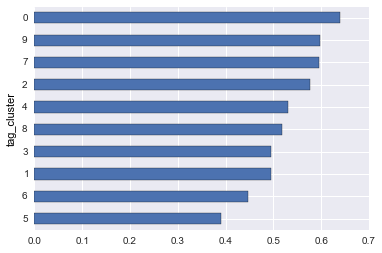

In [13]:
data['tag_cluster'] = model.predict(X)
s = data.groupby('tag_cluster').OpenStatus.mean().sort(inplace=False)
f = s.plot(kind='barh')

We difference in closings per cluster suggests we could try extracting some value from this.

We leave it as an exercise to verify if adding these clusters to your feature matrix indeed leads to a higher oreduction accuracy.

#### Jaccard distance

The _Jaccard distance_ is a distance metric between text documents. It measures how many words two documents have in common, as a fraction of the total number of distinct words in both documents.

$$\text{Jaccard distance} = \frac{ |A \cap B | }{ |A \cup B| }$$

We could also use it for comparing our tags: how many documents do two tages have in common?

In [15]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000,
                     min_df=10, max_df=.95, binary=True)  # binary=True is important!
X = cv.fit_transform(data.tags)

CPU times: user 925 ms, sys: 19 ms, total: 944 ms
Wall time: 934 ms


Let's create the Jaccard matrix:
- `J[i, j]` = # words in common by doc `i` and `j`, over the total # of distinct words in `i` and `j`
- `J[i, i]` = 1, obviously, and
- `J[i, j]` = `J[i, j]`

If we really want a _distance_, we want `J[i, i]` = 0, and bigger numbers the furter away a tag is. Let's define `Jinv = 1 - J` that has this property.

In [16]:
n_tags = X.shape[1]  # number of tags
I = X.T.dot(X).toarray()  # X-transposed times X gives a tag x tag matrix with the # of docs in common
n_docs = np.diag(I)  # number of docs per tag
# U = np.array([[n_docs[i] + n_docs[j] - I[i, j] for i in xrange(n_tags)] for j in xrange(n_tags)])  # this is slow
N = np.array([n_docs] * n_tags)  # number of docs broadcasted over the entire row
U = N + N.T - I  # total distinct docs = n_docs_i + n_docs_j - words in common
J = I / U.astype(float)
Jinv = 1 - J

Let's pick a few random tags and see what the closest tags are.

In [17]:
top = 10
tags = np.array(cv.get_feature_names())
for no in np.random.choice(n_tags, top, replace=False):  # pick 10 random tags
    print "%-18s:" % tags[no], " ".join(tags[Jinv[no].argsort()[:top]])

backup            : backup restore backups ntfs strategy sd rsync mysqldump s3 copy
textures          : textures direct3d lwjgl shader webgl texture glsl transparency overlay opengl
utility           : utility scan small method thumbnail paging quality projects productivity navigation
conf              : conf httpd virtualhost vhosts autotools ogg alias password protection apache
cpan              : cpan rpc perl polls module standards crash date text search
branch            : branch merge git mercurial master svn tortoisesvn tfs complex spaces
development       : development career environment professional enterprise software web education jobs self
reverse           : reverse engineering proxy geocoding decompiling assembly apache2 checksum x86 diagram
markers           : markers maps shortest opacity kml selection zoom center add checkbox
handle            : handle firemonkey mouse global cursor click reverse conventions naming intent


Makes sense. Some tags have more meaning than others, I expect. Note that this is **not** a partitioning, as we only have a distance between words.

We could also apply `KMeans` to this Jaccard matrix, as the entries are indeed distances.

In [18]:
model.fit(Jinv)
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()
for i in range(n_clusters):
    print "Cluster %d:" % i, " ".join(tags[order_centroids[i, :top]])

Top 10 tags per cluster:
Cluster 0: gpl licensing lgpl license organizing bsd opensource tagging copyright folders
Cluster 1: web net server asp code programming sql framework ruby data
Cluster 2: reports appstore approval crystal jni jasper loading recognition lazy opengl
Cluster 3: cream sandwich ice honeycomb softkeyboard decompiling launcher spinner htc fullscreen
Cluster 4: objective cocoa iphone ios touch xcode core osx ipad sdk
Cluster 5: 960 gs queries media aggregate functions responsive viewport compass models
Cluster 6: studio visual continuous 2010 automated tests build integration command line
Cluster 7: intellij idea ide glassfish hints tips jslint proguard jdeveloper completion
Cluster 8: chrome extension firefox google addon safari browser methods devtools opera
Cluster 9: swipe gesture softkeyboard uiscrollview scrollview uiimageview edittext scroll horizontal uiviewcontroller


That looks quite promising.

Unfortunately, the model has put a lot of tags into the same cluster again:

In [19]:
np.unique(model.predict(Jinv), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  15, 3072,   51,    3,    8,   23,   39,    2,   12,   10]))